## Sneak Peek: Frank Lab place field analysis using NWB 2.0 + Query Framework (prototype)
This is an sneak peak of an approach for querying and analyzing NWB 2.0 files in the Frank Lab. We would like to build a Query Framework for efficiently working with data stored in NWB files, including eventually querying across days, animals, and even experiments. As a first step toward this goal,
we show some canonical Frank Lab queries and analyses using a single day of an animal from one experiment. 

In addition to vanilla NWB, we use Frank Lab NWB extensions for representing behavioral tasks and apparatuses. See 'create_franklab_nwbfile.ipynb' for a walk-through of how we create these NWB files. Running that notebook first will create an NWB file that works with this notebook.

We have also developed helper classes (nwb_query.py) for effectively querying data, especially time queries (i.e. selecting subsets of data in particular intervals of time). Importantly, these classes keep track of the valid intervals (i.e. observation intervals) over which the data are valid/observed. In fact, we require all time-based data (e.g. position, speed, spiking, LFP) to have associated valid intervals, because otherwise we cannot interpret the data or even compute common metrics like rate.

These classes are still protoypes. Some of the features (e.g. valid intervals on all TimeSeries) might be incorporated into NWB itself, while other aspects (e.g. Time Queries that keep track of valid intervals) could become part of our future Query Framework.


In [1]:
%load_ext autoreload
%autoreload 2

# General
import pynwb
import numpy as np
import pandas as pd
import networkx as nx

# Local
from franklabnwb.nwb_query import TimeIntervals as TI
from franklabnwb.nwb_query import ContinuousData, PointData, EventData, TimeIntervals, plot_PointData_multiple, plot_ContinuousData, plot_EventData, point_to_line_dist
import franklabnwb.fl_extension_helpers as flh


# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.solid_capstyle': 'butt'})
mdates.rcParams.update({'date.autoformatter.microsecond': '%H:%M:%S.%f'})

### Data import and analysis parameters
We will analyze data for one day of data for one animal, focusing particularly on a single epoch of behavioral data and a single clustered unit for spiking data.

In [2]:
# what data to analyze
d = {}
d['anim'] = 'bon'
d['day'] = 4 # 1-indexed
d['epoch'] = 4 # 1-indexed
d['cluster_id'] = 30

# analysis configuration
c = {}
c['speed_threshold'] = 0.05 # m/s

### Read NWB file
For a walk-through of how to create an NWB file from data in the Frank Lab's old Matlab "Filter Framework" format, see the notebook 'create_franklab_nwbfile.ipynb'.

In [3]:
animday = '{}{:02d}'.format(d['anim'], d['day'])
nwb_filename = './' + animday + '.nwb'

io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf = io.read()
sst = nwbf.session_start_time.timestamp()


print('Successfully loaded %s' % nwb_filename)
print(nwbf)

Successfully loaded ./bon04.nwb

root <class 'pynwb.file.NWBFile'>
Fields:
  acquisition: { LFP <class 'pynwb.ecephys.LFP'> }
  analysis: { }
  devices: { NSpike acquisition system <class 'pynwb.device.Device'> }
  electrode_groups: { 04-01 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-02 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-03 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-04 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-05 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-06 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-07 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-08 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-10 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-11 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-12 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-13 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-14 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-15 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-17 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-18 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-19 <class 

### Dataset Query: speed of the animal across all epochs
#### NWBFile (one animal, day) --> ContinuousData (speed)

We first query for the animal's speed data across all epochs. 

We use these data to create a <i>ContinuousData</i> object, which is designed for data that are, in principle, continuous functions that have a value at all time points. For example, the animal has a speed at all times, but we only sample the animal's speed at some rate (e.g. our video framerate). The speed samples represent a model of the underlying continuous function.

Why do we convert to a new object like ContinuousData instead of just use the existing PyNWB API? Throughout this notebook, we are prototyping a Query Framework, which would allow us to easily slice and dice our data. Importantly, this Query Framework should keeping track of the so-called "valid intervals": the time ranges over which our data are valid. As such, all of our time-based data will be required to have associated valid intervals. Here, the valid intervals are defined by the start and stop times of the epochs.

In [4]:
# Get the start/stop times of each epoch. These are the "valid intervals" of our behavioral data.
epoch_intervals = np.column_stack((nwbf.epochs['start_time'][:], 
                                   nwbf.epochs['stop_time'][:]))


# Get the speed TimeSeries object from PyNWB.
speed_timeseries = nwbf.modules['Behavior']['Speed']['time_series']


# Build a new ContinuousData object.
speed_all_epochs = ContinuousData(samples=pd.DataFrame(data=speed_timeseries.data[()], columns=['speed']), 
                                  sample_times=speed_timeseries.timestamps[()], 
                                  valid_intervals=epoch_intervals)

print("Here, the valid intervals over which we have speed data are defined by the epoch start/stop times:\n")
print(speed_all_epochs.valid_intervals)

Here, the valid intervals over which we have speed data are defined by the epoch start/stop times:

TimeIntervals([1136405800.0,1136407200.0] | [1136407300.0,1136408200.0] | [1136408300.0,1136409200.0] | [1136409300.0,1136410200.0] | [1136410400.0,1136411600.0] | [1136412200.0,1136413200.0] | [1136413300.0,1136414200.0])


### Time Query: animal speed in one epoch
#### ContinuousData (speed), epoch --> ContinuousData (speed in one epoch)

Next, we query for the speed of the animal during a single epoch by executing a <i>time query</i>. A time query simply selects a subset of the speed data occurring within some time interval (or set of intervals). Here, we select the speed data within the start/stop times of a single epoch.

We automatically handle the valid intervals, so that the new ContinuousData object (speed in one epoch) will have the appropriate valid intervals. Namely, it will be the intersection of the original valid intervals (the epoch start/stop times) and the time interval we queried for (the start/stop of the epoch of interest). In this case, the valid interval of our time query perfectly overlaps one of the epochs in the original data, but this need not be the case. The resulting data will never include invalid times.

In [5]:
# Start/stop of the epoch
epoch_start_stop = np.array([nwbf.epochs['start_time'][d['epoch']-1], 
                             nwbf.epochs['stop_time'][d['epoch']-1]])

# Time query to select the epoch
speed = speed_all_epochs.time_query(epoch_start_stop)


print("Doing a time query for epoch %s..." % d['epoch'])
print("Resuls in a ContinuousData object (speed in this epoch) that has the correct valid intervals for this epoch:\n")
print(str(speed.valid_intervals))

Doing a time query for epoch 4...
Resuls in a ContinuousData object (speed in this epoch) that has the correct valid intervals for this epoch:

TimeIntervals([1136409300.0,1136410200.0])


### Dataset Query for position of the animal, followed by Time Query for position in a single epoch
#### 1. NWBFile (one animal, day) --> ContinuousData (position)
#### 2. ContinuousData (position), epoch --> ContinuousData (position in one epoch)

Just as we did for speed, we now build a ContinuousData object for the animal's position across all epochs. Again, this is because position is a continuous function (i.e. the animal has a position at all time points), but we only sample this continuous function at some sample times.

Then, as with speed, we execute a time query to get the animal's position during a single epoch.

*** All position records for epoch ***
# of measurements = 26254
# of intervals = 1
duration of intervals = 896.00 s


/Users/tjd/conda/envs/pynwb/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


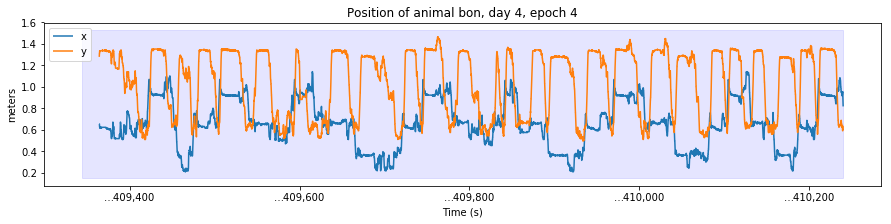

In [6]:
# --------------------
# 1. Dataset Query for the animal's position across all epochs, and create a ContinuousData object.
# Note that position shares the same epoch start/stop times (i.e. same valid intervals) as speed.
# --------------------
pos_timeseries = nwbf.modules['Behavior']['Position']['time_series']
pos_all_epochs = ContinuousData(samples=pd.DataFrame(data=pos_timeseries.data[()], columns=['x', 'y']), 
                                sample_times=pos_timeseries.timestamps[()], 
                                valid_intervals=epoch_intervals)

# --------------------
# 2. Time Query selecting the animal's position only during a single epoch
# Note that we are querying for the same epoch as we did for speed.
# --------------------
epoch_start_stop = np.array([nwbf.epochs['start_time'][d['epoch']-1], 
                             nwbf.epochs['stop_time'][d['epoch']-1]])
position = pos_all_epochs.time_query(epoch_start_stop)



print('*** All position records for epoch ***')
print('# of measurements = %d' % position.samples.shape[0])
print('# of intervals = %d' % len(position.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(position.valid_intervals.durations()))

fig1 = plt.figure(1, figsize=(15,3))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_title('Position of animal %s, day %s, epoch %s' % (d['anim'], d['day'], d['epoch']))
ax1.set_ylabel('meters')
plot_ContinuousData(position)
pass

### Dataset Query: spiking of a given animal and cluster
#### NWBFile (one animal), cluster --> PointData (spiking)

We distinguish between continuous data (e.g. speed, position, head direction) from discrete point data (e.g. spiking, nose pokes) even though these are both frequently represented as "time series" data. This is because our interpretation of these data types--"continuous data" vs. "point data"--are fundamentally different. For continuous data, samples represent a model of the underlying continuous function, so it makes sense to, for example, interpolate between samples. In contrast, for discrete point data, samples are better though of as events generated by some underlying "point process", or as a series of delta functions.

Now we will query for the spiking data of one clustered unit. These data are found in 'units', which is a table with a row for each clustered unit. The spike times live in the column called 'spike_times'. We also grab the 'obs_intervals' column, which contain the intervals over which we were recording from the cell, and thus when it was even possible to see a spike. 

Observation intervals are essential for interpreting these data, because we can only compute metrics like spike rate with respect to the time over which it was possible for us to see a spike. As we start slicing time windows of a spiking record, it can quickly become messy to keep track of these observation intervals (often requiring intersections of many different intervals). Thus, we propose that all time-based data in the Query Framework will include observation intervals.

Unlike speed and position, unit spiking is not a continuous function, but instead can be thought of as a "point process" or a series of delta functions. We represent the unit spiking data as a PointData object, being sure to also provide the observation intervals.


In [7]:
spikes_t = nwbf.units['spike_times'][d['cluster_id']]
valid_intervals = TimeIntervals(nwbf.units['obs_intervals'][d['cluster_id']])
spiking_all = PointData(point_times=spikes_t, valid_intervals=valid_intervals)

print('*** Spiking for cluster %s ***' % d['cluster_id'])
print('# of spikes = %d' % spiking_all.point_times.shape[0])
print('# of intervals = %d' % len(spiking_all.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_all.valid_intervals.durations()))

*** Spiking for cluster 30 ***
# of spikes = 2192
# of intervals = 7
duration of intervals = 7163.00 s


### Time Query: Find spiking within all epochs where the rat did the W-alternation task
#### PointData (spiking), TimeIntervals (epochs) --> PointData (spiking)

The 'epochs' field of the NWBFile is a table with a row for each epoch. This table contains the start and stop times of each epoch, as well as the task that the animal was doing during that epoch. 

Here, we identify the epochs in which the animal was conducting a behavioral task called 'W-alternation'. We use these time intervals to query the spiking PointData, resulting in a new PointData object containing only the spiking data in W-alternation epochs. The valid intervals of this new PointData object are the intersection of the valid_intervals for all spiking data and the time intervals defining the W-alternation epochs. (see plot below)

*** Spiking for cluster 30 during W-Alternation behavioral epochs ***
# of spikes = 1791
# of intervals = 3
duration of intervals = 2704.00 s


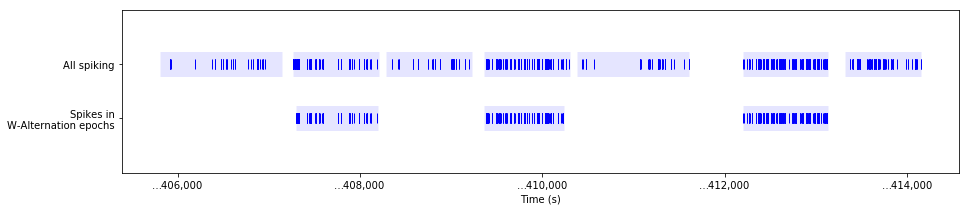

In [8]:
# Get start/stop times for all epochs where the rat ran the W Alternation task
epoch_types = np.array([task.name for task in nwbf.epochs['task'][:]])
behav_epoch_indices = np.where(epoch_types=='W-Alternation')[0]

# Build a TimeIntervals query with start/stop times of W Alternation behavioral epochs
behav_intervals = []
for i in behav_epoch_indices:
    epoch_start = nwbf.epochs['start_time'][i]
    epoch_stop = nwbf.epochs['stop_time'][i]
    behav_intervals.append([epoch_start, epoch_stop])
behav_intervals = TimeIntervals(np.array(behav_intervals)) # convert to TimeIntervals for query

# time_query on spiking during W Alternation behavioral epochs
spiking_behav = spiking_all.time_query(behav_intervals)

print('*** Spiking for cluster %s during W-Alternation behavioral epochs ***' % d['cluster_id'])
print('# of spikes = %d' % spiking_behav.point_times.shape[0])
print('# of intervals = %d' % len(spiking_behav.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_behav.valid_intervals.durations()))

# Plot spiking
spikeplots = [(spiking_all, 'All spiking'),
              (spiking_behav, 'Spikes in\nW-Alternation epochs')]

fig1 = plt.figure(1, figsize=(15,3))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)

pass # suppress output
    


### Time Query: Find spiking within a single behavioral epoch
#### PointData (spiking), TimeIntervals (epoch) --> PointData (spiking)

Now we want to query for spiking in a single epoch of interest. We get the start and stop times of this epoch from the 'epochs' table, and then we use this time interval to query the spiking PointData. This results in a new PointData with just the spiking and valid intervals from that epoch.

*** Spiking for cluster 30 during epoch 4 ***
# of spikes = 672
# of intervals = 1
duration of intervals = 876.00 s


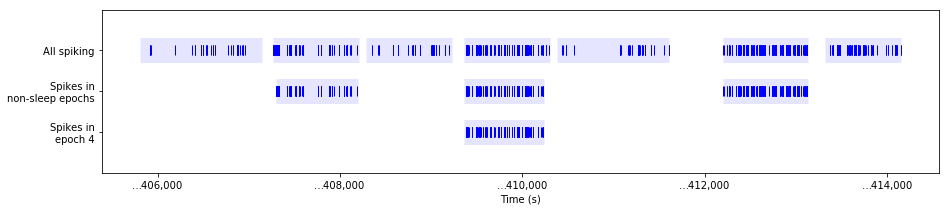

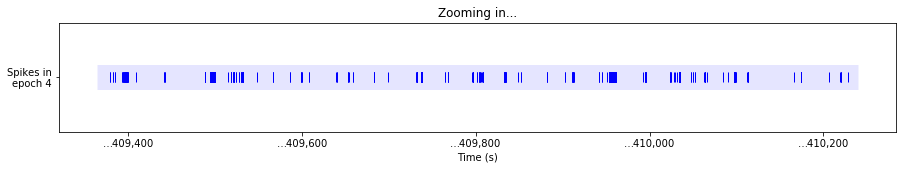

In [9]:
# Get epoch start/stop times from the NWB file
epoch_start = nwbf.epochs['start_time'][d['epoch']-1]
epoch_end = nwbf.epochs['stop_time'][d['epoch']-1]
epoch_interval = TimeIntervals(np.array([epoch_start, epoch_end]))

# time_query on spiking during the epoch
spiking = spiking_all.time_query(epoch_interval)

print('*** Spiking for cluster %s during epoch %d ***' % (d['cluster_id'], d['epoch']))
print('# of spikes = %d' % spiking.point_times.shape[0])
print('# of intervals = %d' % len(spiking.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking.valid_intervals.durations()))


# Plot spiking
spikeplots = [(spiking_all, 'All spiking'),
              (spiking_behav, 'Spikes in\nnon-sleep epochs'),
              (spiking, 'Spikes in\nepoch %s' % d['epoch'])]

fig1 = plt.figure(1, figsize=(15,3))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)

fig2 = plt.figure(2, figsize=(15,2))
ax2 = fig2.add_subplot(1, 1, 1)
plot_PointData_multiple([spikeplots[2]], axis=ax2)
ax2.set_title("Zooming in...")

pass # suppress output

### Analysis: Find time intervals where speed > threshold
#### ContinuousData (speed), lambda function --> EventData (time periods where animal speed > threshold)
Next, we want to find the time intervals within an epoch during which the animal was running faster than some speed threshold. 

Conceptually, we view this as an _analysis_, not a query like the time queries for epochs shown above. This is because we are not simply selecting a direct subset of a given data. Rather, we are asking for the set of time intervals when the speed data fulfills a function given boolean labmda function. The lambda function could have been something different, like "find the times of all upward threshold crossings, and then pad this by 5 seconds on either side." We only mention this to clarify our terminology when we speak of queries and analyses.

The resulting set of time intervals is neither a continuous functions (ContinuousData) or a discrete point processes (PointData). It is somewhat similar to a PointData, but instead of delta functions, we have a set of time intervals. As this is also a common form of data in an analysis workflow, we represent these with an EventData class. In the plot below, each vertical bar is actually a time interval where the animal was running, not a delta function like spiking.

*** Times where speed > threshold ***
# of events = 113
duration of events = 375.04 s
# of valid intervals = 1
duration of intervals = 896.00 s


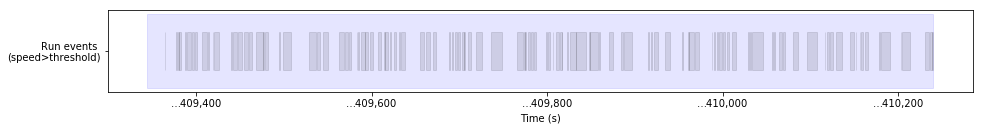

In [10]:
speed_threshold_fn = lambda x: x > c['speed_threshold']
speed_events = speed.filter_intervals(speed_threshold_fn)

print('*** Times where speed > threshold ***')
print('# of events = %d' % len(speed_events.event_intervals))
print('duration of events = %0.2f s' % np.sum(speed_events.durations()))
print('# of valid intervals = %d' % len(speed_events.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(speed_events.valid_durations()))

# TODO: Plot continuous speed
fig1 = plt.figure(1, figsize=(15.5,1.5))
ax1 = fig1.add_subplot(1, 1, 1)
plot_EventData(speed_events, axis=ax1)
ax1.set_yticks([1])
ax1.set_yticklabels(['Run events \n(speed>threshold)']) # eventually use metadata from PointData object
pass # suppress output

### Query: spiking during time intervals where speed > threshold
#### PointData (spiking), EventData (bouts where speed > threshold) --> PointData (spiking)
Now we want to query for spiking data during all of the time intervals where the animal was running above threshold (i.e. during all of the grey intervals in the plot above). To do this, we run a time query on the PointData object containing all spiking, passing in the EventData intervals from above. This results in a new PointData object whose valid intervals are the intersection of the running event intervals and the original spiking valid intervals. Here you can start to see how nice it is to have the valid intervals calculation handled for you behind the scenes. Some of these intervals contain spiking! (see plot below)

*** Spiking where speed > threshold ***
# of spikes = 330
# of intervals = 113
duration of intervals = 375.04 s



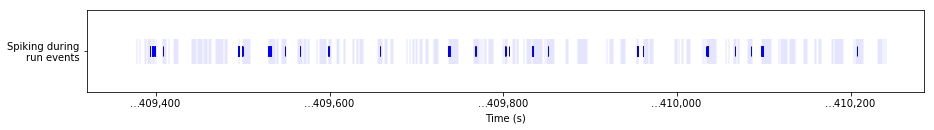

In [11]:
spiking_run = spiking.time_query(speed_events)  # Use the built-in time query method on PointProcess

print('*** Spiking where speed > threshold ***')
print('# of spikes = %d' % len(spiking_run.point_times))
print('# of intervals = %d' % len(spiking_run.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run.valid_intervals.durations()))
print()

# print(spiking_run)

# Plot spiking
fig1 = plt.figure(1, figsize=(15,1.5))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple([(spiking_run, 'Spiking during\nrun events')], axis=ax1)

pass # suppress output

### Analysis: Mark each spike with the animal's current position
#### PointData (spiking), ContinuousData (position [m x 2]) --> PointData with marks (spike times with associated positions)

Now that we have spiking during run periods, we want to associate each of these spike times with the animal's position at the time of the spike. This will be essential in building place fields for units. The process of associating each spike with associated position data can be thought of as "marking" the spike times with the position data. 

Since this is a common analysis step, we provide common functionality for marking PointData (e.g. spiking) with a ContinuousData (e.g. position). This method will automatically interpolate the ContinuousData function at the time of each spike.

In [12]:
spiking_run_mark_pos = spiking_run.mark_with_ContinuousData(position)

print('*** Spiking where speed > threshold, marked with position ***')
print('# of marked spikes = %d' % len(spiking_run_mark_pos.point_times))
print('# of intervals = %d' % len(spiking_run_mark_pos.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run_mark_pos.valid_intervals.durations()))
print()

*** Spiking where speed > threshold, marked with position ***
# of marked spikes = 330
# of intervals = 113
duration of intervals = 375.04 s



### Query: Get animal locations during running events
#### ContinuousData (position [m x 2]), EventData (bouts where speed > threshold) --> ContinuousData (position [m_new x 2])

We are also interested in analyzing the animal's position during running periods.  We do a time query on the animal's position, querying for the positions during any of the set of time intervals when the animal was running. As before, the valid intervals are handled automatically for us behind the scenes, in this case intersecting the many running intervals with the position data.

The plot below shows the steps of theis process: 
1. the animal's x/y position (ContinuousData)
2. the animal's speed (ContinuousData)
3. the time intervals when speed > threshold (Event Data)
4. x/y position during running intervals (time query on ContinuousData with EventData input)

*** Position where speed > threshold ***
# of samples = 11353
# of intervals = 113
duration of intervals = 375.04 s



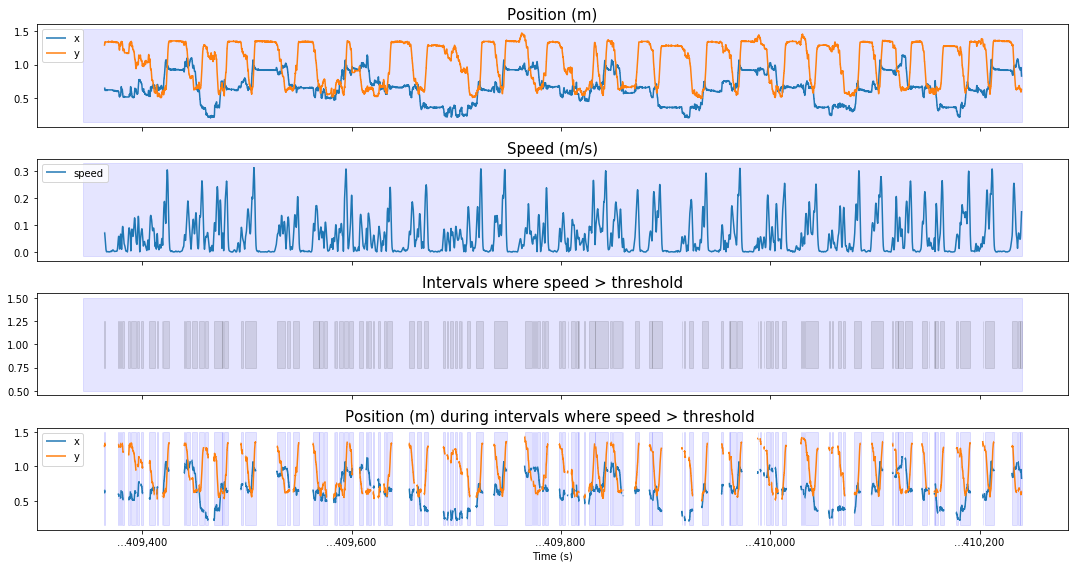

In [13]:
position_run = position.time_query(speed_events)

print('*** Position where speed > threshold ***')
print('# of samples = %d' % position_run.samples.shape[0])
print('# of intervals = %d' % len(position_run.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(position_run.valid_intervals.durations()))
print()

fig1 = plt.figure(1, figsize=(15,8))
ax1 = fig1.add_subplot(4, 1, 1)
ax1.set_title('Position (m)', fontsize=15)
plot_ContinuousData(position, axis=ax1)
ax1.label_outer()

ax2 = fig1.add_subplot(4, 1, 2, sharex=ax1)
ax2.set_title('Speed (m/s)', fontsize=15)
plot_ContinuousData(speed, axis=ax2)
ax2.set_xlabel('')
ax2.label_outer()

ax3 = fig1.add_subplot(4, 1, 3, sharex=ax1)
ax3.set_title('Intervals where speed > threshold', fontsize=15)
plot_EventData(speed_events, axis=ax3)
ax3.label_outer()

ax4 = fig1.add_subplot(4, 1, 4, sharex=ax1)
ax4.set_title('Position (m) during intervals where speed > threshold ', fontsize=15)
plot_ContinuousData(position_run, axis=ax4)
# ax1.set_xlim(1136409500, 1136409600)

plt.tight_layout()

pass

### Plot spikes by location

We now plot three pieces of information:
1. rat position during all times (ContinuousData)
2. rat position during running (ContinuousData, result of time query on running intervals)
3. rat position during spike times (PointData marked with position: plot the marks for each spike time)

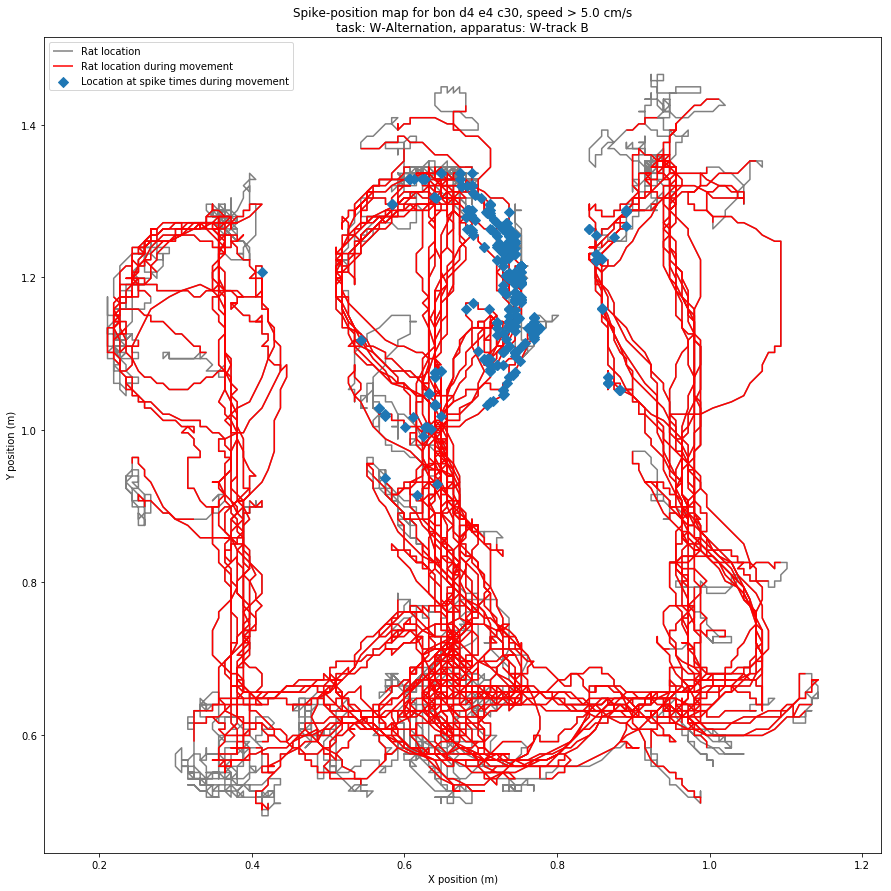

In [14]:
fig1 = plt.figure(1, figsize=(15,15))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.axis('equal')


task = nwbf.epochs['task'][d['epoch']-1]
appar = nwbf.epochs['apparatus'][d['epoch']-1]

# Line showing the animal's movement during the entire epoch
plt.plot(position.samples['x'], position.samples['y'], marker='', color='gray', label='Rat location', zorder=1)

# Lines showing animal movement during each interval where it was running
run_label = 'Rat location during movement'
for ivl in position_run.valid_intervals:
    ivl_data = position.time_query(TimeIntervals(ivl)).samples  # position at this valid interval 
    plt.plot(ivl_data['x'], ivl_data['y'], marker='', color='red', label=run_label, zorder=2)
    run_label = '_' # omit later lines from legend

# Markers for locations where unit spiked during animal running
plt.scatter(spiking_run_mark_pos.marks['x'], spiking_run_mark_pos.marks['y'], marker='D', s=50, label='Location at spike times during movement', zorder=3)

ax1.legend()
ax1.set_xlabel('X position (m)')
ax1.set_ylabel('Y position (m)')
ax1.set_title('Spike-position map for {} d{} e{} c{}, speed > {:0.1f} cm/s\ntask: {}, apparatus: {}'.format(
    d['anim'], d['day'], d['epoch'], d['cluster_id'], c['speed_threshold'] * 100, task.name, appar.name))

pass

### Dataset Query: Task and Apparatus

We also want to know some metadata about this epoch, including 
1. the Task that the animal was doing (e.g. W-alternation, Exploration, Sleep)
2. the Apparatus that the animal was on (e.g. W-track A, Sleep box, Linear track)

These are found in the 'epochs' table in the 'task' and 'apparatus' columns, respectively. The Task and Apparatus objects are both part of the Frank Lab NWB extensions. Task just contains a name and description of the task. Apparatus is a bit more complicated; it is a graph (nodes and edges) representing the topology/connectivity of the apparatus. The nodes in the graph contains coordinates that specify the geometry of the apparatus.

For details on how these objects are generated, see create_franklab_nwbfile.ipynb. For details on the Frank Lab NWB extensions, see fl_extension.py (for the available classes), create_franklab_spec.ipynb (for creation of the YAML spec), and franklab.extensions.yaml (for the spec itself. 


In [15]:
# Query for task
# NWBFile (one animal, day), epoch --> franklab_apparatus.Task
task = nwbf.epochs['task'][d['epoch']-1]

# Query for apparatus
# NWBFile (one animal, day), epoch --> franklab_apparatus.Apparatus
appar = nwbf.epochs['apparatus'][d['epoch']-1]

print('The task is just a name and description:')
print(task)
print('\n')
print('The apparatus is a graph (nodes and edges) representing topology/connectivity and geometry:')
print(appar)

The task is just a name and description:

W-Alternation <class 'fl_extension.Task'>
Fields:
  description: The animal runs in an alternating W pattern between three neighboring arms of a maze.



The apparatus is a graph (nodes and edges) representing topology/connectivity and geometry:

W-track B <class 'fl_extension.Apparatus'>
Fields:
  edges: { left arm<->left_branch <class 'fl_extension.Edge'>,  left reward well<->left arm <class 'fl_extension.Edge'>,  left_branch<->right_branch <class 'fl_extension.Edge'>,  middle arm<->left_branch <class 'fl_extension.Edge'>,  middle arm<->right_branch <class 'fl_extension.Edge'>,  middle reward well<->middle arm <class 'fl_extension.Edge'>,  right arm<->right_branch <class 'fl_extension.Edge'>,  right reward well<->right arm <class 'fl_extension.Edge'> }
  nodes: { left arm <class 'fl_extension.SegmentNode'>,  left reward well <class 'fl_extension.PointNode'>,  left_branch <class 'fl_extension.SegmentNode'>,  middle arm <class 'fl_extension.Seg

### Plot 2D position-normalized spiking

Now we have all the pieces necessary to plot the 2D position-normalized spiking for this unit. Below, we plot the steps of this process:
1. time (sec) the animal spent at different locations
2. number of spikes (spike count) when the animal was at differnt locations
3. position-normalized spike rate (spikes per sec that the animal was in a given location)

We can see that the position-normalized spike rate (fig.3) reflects the spike-position figure from the previous cell.

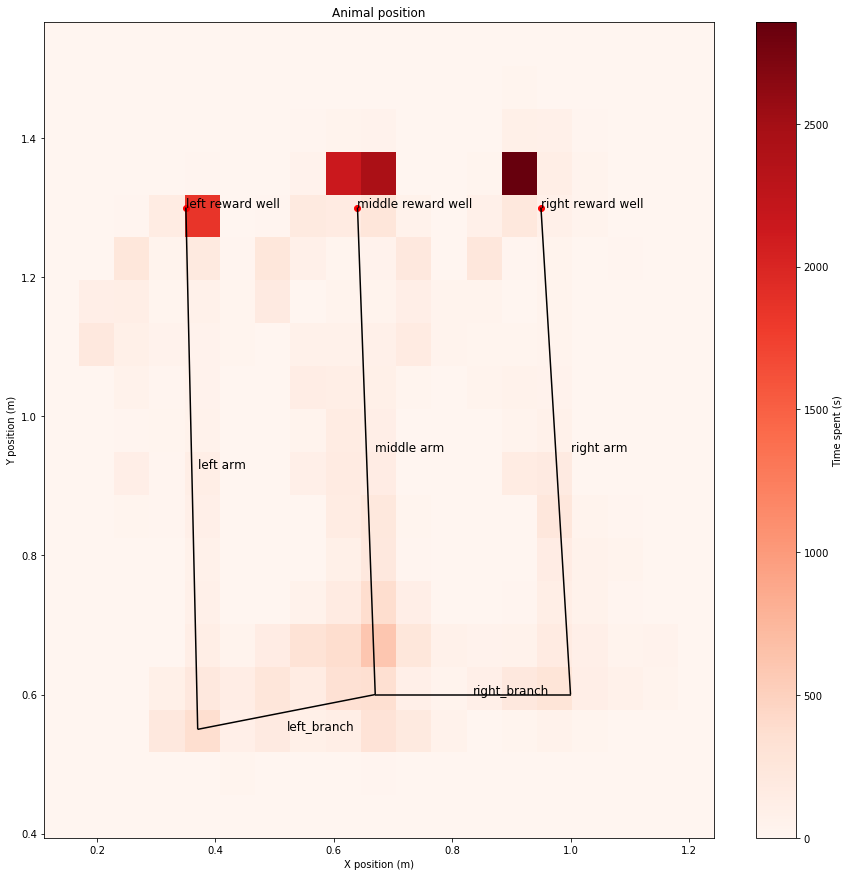

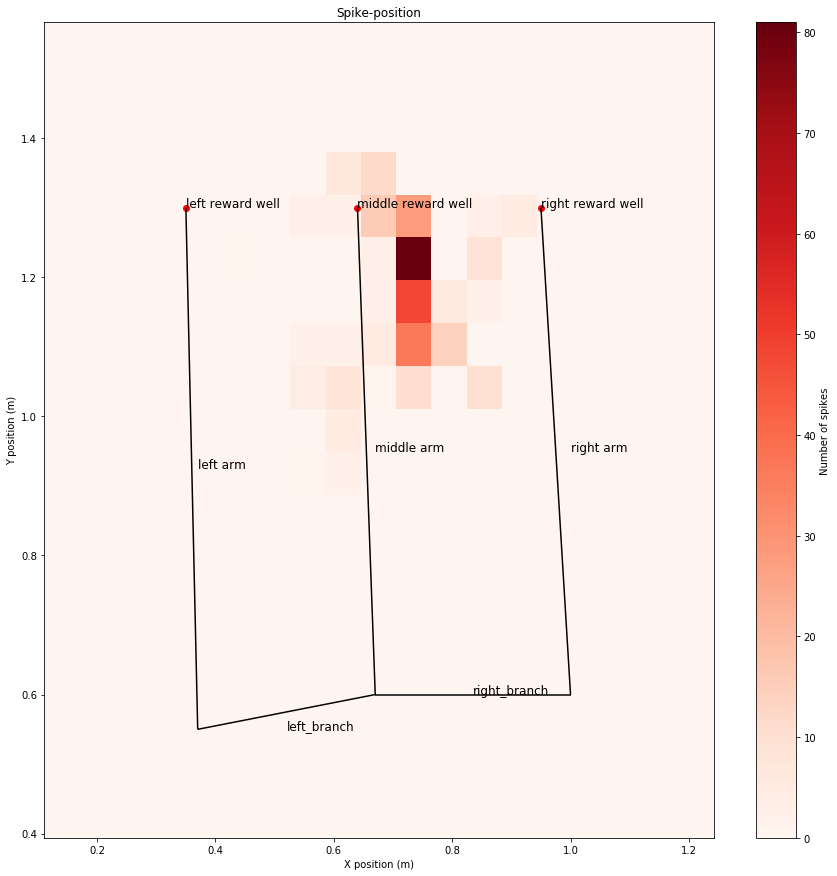

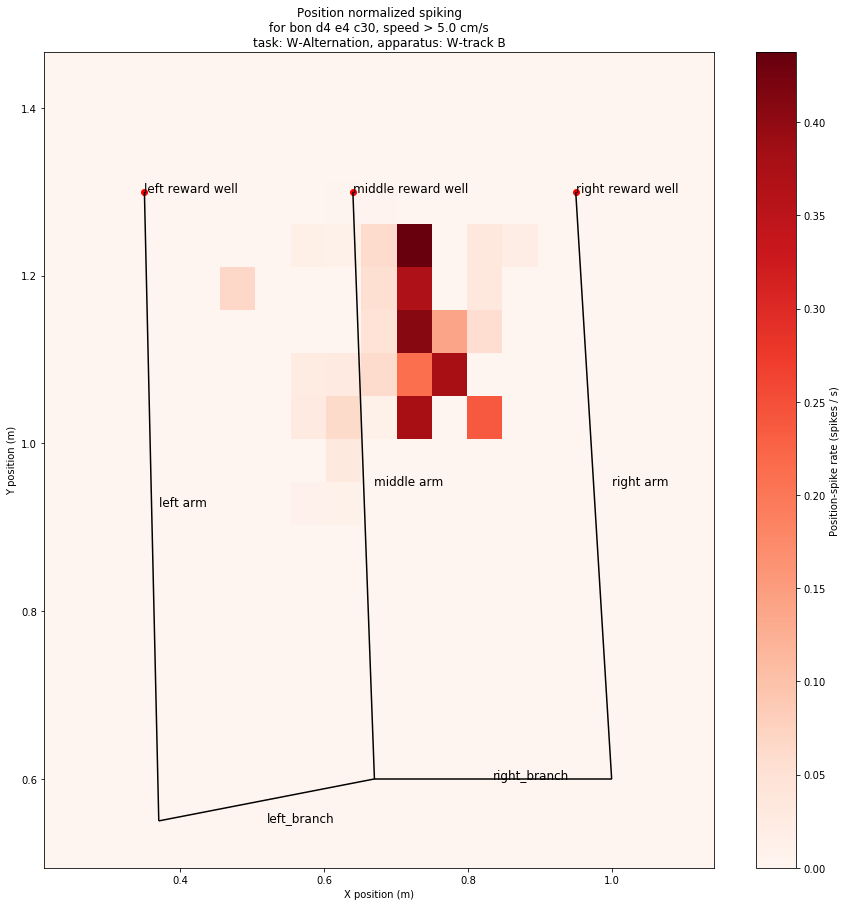

In [16]:


padding = 0.1
nbins = 20
minx = np.min(position.samples['x'])
maxx = np.max(position.samples['x'])
miny = np.min(position.samples['y'])
maxy = np.max(position.samples['y'])
binsx = np.linspace(minx-padding, maxx+padding, nbins)
binsy = np.linspace(miny-padding, maxy+padding, nbins)

# Compute histogram of position during entire epoch
fig1 = plt.figure(figsize=(15,15))
ax1 = plt.subplot(111)
plt.title('Animal position')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
n_pos, xbins_pos, ybins_pos, img_pos = plt.hist2d(position.samples['x'], position.samples['y'], bins=[binsx, binsy], cmap='Reds')
cbar = plt.colorbar()
cbar.set_label('Time spent (s)')
flh.plot_fl_appar_geom(appar, ax1, label_nodes=True) # Plot apparatus geometry


# Compute histogram of position during spiking
fig2 = plt.figure(figsize=(15,15))
ax2 = plt.subplot(111)
plt.title('Spike-position')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
n_spikes, xbins_spikes, ybins_spikes, img_pos = plt.hist2d(spiking_run_mark_pos.marks['x'], spiking_run_mark_pos.marks['y'], bins=[binsx, binsy], cmap='Reds')
cbar = plt.colorbar()
cbar.set_label('Number of spikes')
flh.plot_fl_appar_geom(appar, ax2, label_nodes=True) # Plot apparatus geometry


# Compute position normalized spiking
n_pos = np.add(n_pos, 0.0001)
norm_spikes = np.divide(n_spikes, n_pos)

# Plot position normalized spiking
fig3 = plt.figure(figsize=fig2.get_size_inches())
ax3 = plt.subplot(111)
plt.title('Position normalized spiking\nfor {} d{} e{} c{}, speed > {:0.1f} cm/s\ntask: {}, apparatus: {}'.format(
    d['anim'], d['day'], d['epoch'], d['cluster_id'], c['speed_threshold'] * 100, task.name, appar.name))
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.imshow(norm_spikes.T, origin='lower', aspect='auto', cmap='Reds', extent=(minx, maxx, miny, maxy))
cbar = plt.colorbar()
cbar.set_label('Position-spike rate (spikes / s)')
flh.plot_fl_appar_geom(appar, ax3, label_nodes=True) # Plot apparatus geometry



### Query for animal positions during sleep epochs, and plot on top of the sleep box geometry
We use the 'epochs' table to find which were sleep epochs. We then get the animal's position during all of these epochs, storing each in a ContinuousData object.

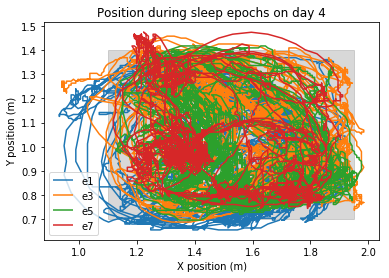

In [17]:
# Get indices of all the sleep epochs
task_names = np.array([task.name for task in nwbf.epochs['task'][:]])
sleep_epochs = np.where(task_names == 'Sleep')[0]

# Plot position of the animal during each sleep epoch
# Using time queries for each sleep epoch
plt.figure()
plt.title('Position during sleep epochs on day {}'.format(d['day']))
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
ax = plt.subplot(111)
for epoch_idx in sleep_epochs:
    epoch_query = TimeIntervals(epoch_intervals[epoch_idx])
    epoch_pos = pos_all_epochs.time_query(epoch_query)
    plt.plot(epoch_pos.samples['x'], epoch_pos.samples['y'], marker='', label='e{}'.format(epoch_idx+1))

# Get the Sleep Box apparatus (Same apparatus for all sleep epochs, so just use the first)
first_sleep_epoch = sleep_epochs[0]
appar = nwbf.epochs['apparatus'][first_sleep_epoch]

# Convert the Frank Lab apparatus to a Network X graph and plot it
H = nx.Graph(name='sleep box')
for n in appar.nodes.values():
    flh.add_fl_node_to_nx_graph(n, H)
flh.plot_nx_appar_geom(H, ax)
ax.legend()
pass

In [18]:
# Close the file io
io.close()